## General Description

1. Create Datasets
2. Create AF jobs
3. analyze AF output

## 1. Create Datasets

### Library imports and helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions_filtering import *

### Constants

In [2]:
STRING_PATH = '/home/markus/MPI_local/data/STRING/9606.protein.physical.links.detailed.v12.0.txt_processed.csv'
PROTEOME_PATH = '/home/markus/MPI_local/data/Proteome/uniprotkb_proteome_UP000005640_2025_05_28.tsv'
# PROTEOME_PATH = '/home/markus/MPI_local/data/full_UP/uniprotkb_AND_reviewed_true_2025_07_10.tsv'
TF_DATASET_PATH = '/home/markus/MPI_local/data/human_TFs/DatabaseExtract_v_1.01.csv'
ENSEMBL_MAPPING_PATH = '/home/markus/MPI_local/data/Ensembl_mapping/Homo_sapiens.GRCh38.114.uniprot.tsv/hps/nobackup/flicek/ensembl/production/release_dumps/release-114/ftp_dumps/vertebrates/tsv/homo_sapiens/Homo_sapiens.GRCh38.114.uniprot.tsv'
AIUPRED_PATH = '/home/markus/MPI_local/data/AIUPred/AIUPred_data.json'
DISPROT_PATH = '/home/markus/MPI_local/data/DisProt/DisProt_release_2024_12 with_ambiguous_evidences.tsv'

import importlib
import constants
importlib.reload(constants)
from constants import *

### Read in Proteome

In [3]:
all_uniprot = pd.read_csv(PROTEOME_PATH, low_memory=False, sep='\t')
uniprot_filtered = all_uniprot[all_uniprot['Reviewed'] == 'reviewed']
# uniprot_filtered = all_uniprot

### create Armadillo dataset

In [4]:
# strip version number since it is not included in the uniprot annotation
arm_accs_pfam_stripped = [acc.split(".")[0] for acc in arm_accs_pfam]
    
# find proteins with "ARM" in their Repeat column
repeat_mask_arm = uniprot_filtered['Repeat'].apply(lambda x: "ARM" in str(x) if pd.notna(x) else False)
print(f"Proteins with 'ARM' in Repeat column: {len(uniprot_filtered[repeat_mask_arm])}")

# Filter rows where InterPro column contains any interpro_annotations
interpro_mask_arm = uniprot_filtered['InterPro'].apply(lambda x: contains_any_annotation(x, arm_accs_ipr))
print(f"Proteins with specified InterPro annotation: {len(uniprot_filtered[interpro_mask_arm])}")

# Filter rows where Pfam column contains any pfam_annotations
pfam_mask_arm = uniprot_filtered['Pfam'].apply(lambda x: contains_any_annotation(x, arm_accs_pfam_stripped))
print(f"Proteins with specified Pfam annotation: {len(uniprot_filtered[pfam_mask_arm])}")

# apply filters using OR
armadillo_proteins = uniprot_filtered[interpro_mask_arm | pfam_mask_arm | repeat_mask_arm]

print(f"Found {len(armadillo_proteins)} proteins with armadillo domains")

Proteins with 'ARM' in Repeat column: 47
Proteins with specified InterPro annotation: 348
Proteins with specified Pfam annotation: 52
Found 348 proteins with armadillo domains


### Create Transcription Factor dataset (UniProtFilter)

In [5]:
# def str_tf(x):
#     return "transcription factor" in x.lower()

# def str_t(x):
#     return "transcription" in x.lower()

# # IPR accessions containing "transcription"
# IPR_entries = pd.read_csv("../entry.list", sep="\t")
# tf_accs_ipr = IPR_entries[IPR_entries['ENTRY_NAME'].apply(lambda x: str_t(x))]["ENTRY_AC"].tolist()

# # PFAM accessions containing "transcription factor"
# PFAM_entries = pd.read_csv("../data/pfam_parsed_data.csv", sep=",")
# tf_accs_pfam = PFAM_entries[PFAM_entries['DE'].apply(lambda x: str_t(x))]["AC"].tolist()

# # strip version number since it is not included in the uniprot annotation
# for i in range(len(tf_accs_pfam)):
#     tf_accs_pfam[i] = tf_accs_pfam[i].split(".")[0]

# interpro_mask_tf = reviewed_proteins['InterPro'].apply(lambda x: contains_any_annotation(x, tf_accs_ipr))
# print(f"Proteins with specified InterPro annotation: {len(reviewed_proteins[interpro_mask_tf])}")

# pfam_mask_tf = reviewed_proteins['Pfam'].apply(lambda x: contains_any_annotation(x, tf_accs_pfam))
# print(f"Proteins with specified Pfam annotation: {len(reviewed_proteins[pfam_mask_tf])}")

# txt_mask_tf = reviewed_proteins['Protein names'].apply(lambda x: str_tf(x))
# print(f"Proteins with 'Transcription factor' in the name: {len(reviewed_proteins[txt_mask_tf])}")


# # Combine filters with OR operation
# tf_proteins_uniprot_ds = reviewed_proteins[interpro_mask_tf | pfam_mask_tf | txt_mask_tf]

# print(f"Found {len(tf_proteins_uniprot_ds)} proteins with transcription factor annotation")

### Use existing Transcription Factor dataset

In [6]:
human_TFs = pd.read_csv(TF_DATASET_PATH)
human_TFs = human_TFs[human_TFs['Is TF?'] == 'Yes']
len(human_TFs)

1639

In [7]:
ensembl_mapping = pd.read_csv(ENSEMBL_MAPPING_PATH, sep='\t')
ensembl_mapping_swissProt = ensembl_mapping[ensembl_mapping['db_name'] == 'Uniprot/SWISSPROT']

In [8]:
human_TFs_gids = human_TFs['Ensembl ID'].tolist()

# Use swiss prot accessions to prevent duplicates
# TODO: use caching
# TODO: adjust ensemble mapping if using other proteome?
human_TF_uniprot_accs = ensembl_mapping_swissProt[ensembl_mapping_swissProt['gene_stable_id'].apply(lambda x: any((id == x) for id in human_TFs_gids))]['xref'].tolist()
print(len(human_TF_uniprot_accs))

tf_proteins_curated_ds = uniprot_filtered[uniprot_filtered['Entry'].apply(lambda x: any((id in x) for id in human_TF_uniprot_accs))]
print(len(tf_proteins_curated_ds))

# 4m 1.7s

4077
1613


#### IUPred 3

In [9]:
tf_proteins_curated_ds = add_iupred3(tf_proteins_curated_ds, 'long', 'no', IUPRED_CACHE_DIR, IUPRED3_THRESHOLD, MIN_LENGTH_DISORDERED_REGION, IUPRED3_PATH)

tf_proteins_curated_ds_IUPred3_diso = tf_proteins_curated_ds[tf_proteins_curated_ds['num_disordered_regions'] > 0]

print(f"Number of transcription factors with at least one disordered region (IUPred3, threshold={IUPRED3_THRESHOLD}, min length={MIN_LENGTH_DISORDERED_REGION}): {len(tf_proteins_curated_ds_IUPred3_diso)}")

/home/markus/MPI_local/src/production1/functions_filtering.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iupred3'] = None
/home/markus/MPI_local/src/production1/functions_filtering.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_disordered_regions'] = None
/home/markus/MPI_local/src/production1/functions_filtering.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Number of transcription factors with at least one disordered region (IUPred3, threshold=0.5, min length=20): 1311


#### Disprot

In [10]:
disprot_df = pd.read_csv(DISPROT_PATH, sep='\t')

# make format the same as in uniprot columns
disprot_df['disprot_id'] = disprot_df['disprot_id'].apply(lambda x: x + ';')

tf_disprot_ids = tf_proteins_curated_ds['DisProt'].dropna().tolist()

disprot_tfs = disprot_df[disprot_df['disprot_id'].apply(lambda x: x in tf_disprot_ids)]

In [11]:
tf_proteins_curated_ds_disprot = tf_proteins_curated_ds.merge(disprot_df, how='left', left_on='DisProt', right_on='disprot_id')

### Create all pairs

In [12]:
all_pairs = create_all_pairs(armadillo_proteins, tf_proteins_curated_ds_IUPred3_diso)

Created 456228 possible protein pairs between 348 armadillo proteins and 1311 transcription factors


In [13]:
num_pairs_over_token_limit = len(all_pairs[all_pairs['Length_arm'] + all_pairs['Length_tf'] > AF_TOKEN_LIMIT])
print(f"Pairs over token limit: {num_pairs_over_token_limit} ({(num_pairs_over_token_limit/len(all_pairs))*100}%)")

Pairs over token limit: 4622 (1.0130899462549425%)


In [14]:
# remove pairs that are in structure dataset

%store -r up_ids_structure_ds

up_ids_structure_ds_sorted = []
for up_pair in up_ids_structure_ds:
    up_pair_clean = [x.upper() for x in up_pair if pd.notna(x)]
    up_pair_clean = tuple(sorted(up_pair_clean))
    up_ids_structure_ds_sorted.append(up_pair_clean)

In [15]:
# Convert pair_id column to tuples for comparison
all_pairs['pair_tuple'] = all_pairs['pair_id'].apply(eval)

# Create a set of structure dataset pairs for faster lookup
structure_pairs_set = set(up_ids_structure_ds_sorted)

# Filter out pairs that are in the structure dataset
initial_count = len(all_pairs)
all_pairs = all_pairs[~all_pairs['pair_tuple'].isin(structure_pairs_set)]
removed = initial_count - len(all_pairs)

# Drop the temporary column
all_pairs = all_pairs.drop('pair_tuple', axis=1)

print(removed)

3


### STRING

In [16]:
# read in the STRING file
# note that the file is a STRING database dump preprocessed with the scripts in /src/STRING 
# it should contain columns p1_Uniprot, p2_Uniprot and pair_id
string_df = pd.read_csv(STRING_PATH, sep=',')

In [17]:
# annotate the all_pairs df with the STRING scores
# IMPORTANT: drop rows that don't have a matching STRING entry
all_pairs_w_STRING = pd.merge(all_pairs, string_df, on='pair_id', how='inner')

# print number of unmatched pairs
unmatched_pairs = all_pairs[~all_pairs['pair_id'].isin(all_pairs_w_STRING['pair_id'])]
num_all_pairs = len(all_pairs)
num_all_pairs_w_STRING = len(all_pairs_w_STRING)
print(f"Number of pairs in all_pairs: {num_all_pairs}")
print(f"Number of pairs successfully merged with STRING data: {num_all_pairs_w_STRING} ({(num_all_pairs_w_STRING/num_all_pairs)*100}%)")

Number of pairs in all_pairs: 456225
Number of pairs successfully merged with STRING data: 2352 (0.5155350978135788%)


### IntAct

In [18]:
from functions_intact import *

In [19]:
intact_cleaned = read_clean_intact('../../data/IntAct/human/human.txt')

Loading cached cleaned data from ../../data/IntAct/human/human.txt.cleaned


In [20]:
all_pairs_w_IntAct = pd.merge(all_pairs, intact_cleaned, on='pair_id', how='inner')

num_all_pairs = len(all_pairs)
num_all_pairs_w_IntAct = len(all_pairs_w_IntAct)
print(f"Number of pairs in all_pairs: {num_all_pairs}")
print(f"Number of pairs successfully merged with IntAct data: {num_all_pairs_w_IntAct} ({(num_all_pairs_w_IntAct/num_all_pairs)*100}%)")

Number of pairs in all_pairs: 456225
Number of pairs successfully merged with IntAct data: 1956 (0.42873582114088443%)


In [21]:
all_pairs_intersect_STRING_IntAct = pd.merge(all_pairs_w_STRING, all_pairs_w_IntAct, on='pair_id', how='inner')
all_pairs_union_STRING_IntAct = pd.merge(all_pairs_w_STRING, all_pairs_w_IntAct, on='pair_id', how='outer')


print(f"Intersection of STRING and IntAct: {len(all_pairs_intersect_STRING_IntAct)}")
print(f"Union of STRING and IntAct: {len(all_pairs_union_STRING_IntAct)}")

Intersection of STRING and IntAct: 852
Union of STRING and IntAct: 3456


In [22]:
# Create predicted dataset by removing pairs that have evidence in STRING or IntAct
pred_ds = all_pairs[~all_pairs['pair_id'].isin(all_pairs_union_STRING_IntAct['pair_id'])]
print(len(pred_ds))

452769


### write to files

In [23]:
# for idx, row in armadillo_proteins.iterrows():
#     print_to_fasta(row['Entry'], row['Sequence'], '../../production1/arm_all_uniprot_rev_fasta', row['Reviewed'])
# for idx, row in tf_proteins_curated_ds_IUPred3_diso.iterrows():
#     print_to_fasta(row['Entry'], row['Sequence'], '../../production1/tf_all_uniprot_rev_fasta', row['Reviewed'])

In [24]:
# armadillo_proteins.to_csv('../../armadillo_proteins.csv', index=False)
# tf_proteins_curated_ds_IUPred3_diso.to_csv('../../transcription_factors.csv', index=False)

## 1.1 PDB reports

### imports and functions

In [ ]:
import functions_analysis
import functions_job_creation
import functions_filtering
import functions_plotting
import functions_download
import importlib

# Reload the module
importlib.reload(functions_analysis)
importlib.reload(functions_job_creation)
importlib.reload(functions_filtering)
importlib.reload(functions_download)
importlib.reload(functions_plotting)

# Step 2: Re-import everything you need
from functions_analysis import *
from functions_job_creation import *
from functions_download import *
from functions_filtering import *
from functions_plotting import *


In [ ]:
def pdb_report_arm_filter(pdb_report: pd.DataFrame, armadillo_proteins: pd.DataFrame) -> pd.DataFrame:
    # filter entries that have at least one ARM, add column isARM = True|False
    keep_pdbs = set()
    armadillo_entries = armadillo_proteins['Entry'].tolist()
    pdb_report['isARM'] = False

    for ind, row in pdb_report.iterrows():
        if pd.notna(row['Accession Code(s)']) and row['Accession Code(s)'] in armadillo_entries:
            keep_pdbs.add(row['Entry ID'])
            pdb_report.at[ind, 'isARM'] = True
    
    pdb_report = pdb_report[pdb_report['Entry ID'].isin(keep_pdbs)]
    return pdb_report

def pdb_report_tf_filter(pdb_report: pd.DataFrame, tf_proteins: pd.DataFrame) -> pd.DataFrame:
    keep_pdbs = set()
    tf_entries = tf_proteins['Entry'].tolist()
    pdb_report['isDisoTF'] = False
    

    for ind, row in pdb_report.iterrows():
        if pd.notna(row['Accession Code(s)']) and row['Accession Code(s)'] in tf_entries:
            keep_pdbs.add(row['Entry ID'])
            pdb_report.at[ind, 'isDisoTF'] = True
    
    pdb_report = pdb_report[pdb_report['Entry ID'].isin(keep_pdbs)]
    return pdb_report

def pdb_report_disorder_filter(pdb_report: pd.DataFrame) -> pd.DataFrame:
    # filter for entries that have at least one protein that is not ARm and has a disordered region
    keep_pdbs = set()

    for _, row in pdb_report.iterrows():
        if row['isARM'] == False and row['num_disordered_regions'] > 0:
            keep_pdbs.add(row['Entry ID'])
            
    pdb_report = pdb_report[pdb_report['Entry ID'].isin(keep_pdbs)]
    return pdb_report

### report 1

In [4]:
pdb_report_1 = pd.read_csv('/home/markus/MPI_local/data/PDB_reports/1/combined_pdb_reports_processed.csv', low_memory=False)

In [5]:
# Get Entry IDs from both datasets
pdb_entry_ids = set(pdb_report_1['Accession Code(s)'].dropna())
tf_entry_ids = set(tf_proteins_curated_ds_IUPred3_diso['Entry'])

# Find intersection
common_entries = pdb_entry_ids.intersection(tf_entry_ids)

print(f"Number of Entry IDs in pdb_report_1_two_seq: {len(pdb_entry_ids)}")
print(f"Number of Entry IDs in tf_proteins_curated_ds: {len(tf_entry_ids)}")
print(f"Number of Entry IDs that appear in both datasets: {len(common_entries)}")
print(f"Percentage of PDB entries that are also TFs: {len(common_entries)/len(pdb_entry_ids)*100:.2f}%")

NameError: name 'tf_proteins_curated_ds_IUPred3_diso' is not defined

In [ ]:
# use only entries where at least one Uniprot ID is in list of disordered TFs
pdb_report_1 = pdb_report_tf_filter(pdb_report_1, tf_proteins_curated_ds_IUPred3_diso)

In [ ]:
# filter entries that have at least one ARM, add column isARM = True|False
pdb_report_1 = pdb_report_arm_filter(pdb_report_1, armadillo_proteins)
# annotate with iupred3
# pdb_report_1 = add_iupred3(pdb_report_1, 'long', 'no', IUPRED_CACHE_DIR, IUPRED3_THRESHOLD, MIN_LENGTH_DISORDERED_REGION, IUPRED3_PATH)

In [ ]:
# find entries that appear exactly twice => arm interacting with tf (since one is arm and the other must be tf)
entry_counts = pdb_report_1['Entry ID'].value_counts()
entries_appearing_twice = entry_counts[entry_counts == 2].index.tolist()
pdb_report_1_seq2 = pdb_report_1[pdb_report_1['Entry ID'].isin(entries_appearing_twice)]

In [ ]:
# filter pairs where ARM and disordered TF is the same protein
keep_pdbs = set()

for ind, row in pdb_report_1.iterrows():
    if not (row['isARM'] == True and row['isDisoTF'] == True):
        keep_pdbs.add(row['Entry ID'])

pdb_report_1 = pdb_report_1[pdb_report_1['Entry ID'].isin(keep_pdbs)]

In [ ]:
# now we have all pairs that have one ARM partner => the other protein must be the TF (candidate), since that was in the original search criteria
# now filter for disordered regions
# pdb_report_1 = pdb_report_disorder_filter(pdb_report_1_seq2)

In [ ]:
download_pdb_structures(set(pdb_report_1['Entry ID'].tolist()))

In [ ]:
entries_appearing_3 = entry_counts[entry_counts == 3].index.tolist()
pdb_report_1_seq3 = pdb_report_1[pdb_report_1['Entry ID'].isin(entries_appearing_3)]

In [ ]:
# create pairs by separating into arm and tf half
report_1_arm = pdb_report_1_seq2[(pdb_report_1_seq2['isARM'] == True) & (pdb_report_1_seq2['Total Number of polymer Entity Instances (Chains) per Entity'] == 1)]
report_1_tf = pdb_report_1_seq2[(pdb_report_1_seq2['isARM'] == False) & (pdb_report_1_seq2['Total Number of polymer Entity Instances (Chains) per Entity'] == 1)]
# report_1_arm = pdb_report_1_seq2[(pdb_report_1_seq2['isARM'] == True)]
# report_1_tf = pdb_report_1_seq2[(pdb_report_1_seq2['isARM'] == False)]

report_1_pairs = pd.merge(left=report_1_tf, right=report_1_arm, on='Entry ID', suffixes=['_tf', '_arm'])
NATIVE_PATH_PREFIX = "/home/markus/MPI_local/data/PDB/"
HPC_FULL_RESULTS_DIR = "/home/markus/MPI_local/HPC_results_full"
PDB_CACHE = '../../production1/pdb_cache'
DOCKQ_CACHE = '../../production1/dockq_cache'
# rename columns for compatibility with annotate_dockq()
report_1_pairs = report_1_pairs.rename(columns={'Entry ID': 'pdb_id'})

# print_dockq(report_1_pairs, NATIVE_PATH_PREFIX, HPC_FULL_RESULTS_DIR, all_uniprot, 'pdb', PDB_CACHE, DOCKQ_CACHE)

report_1_pairs, no_model = append_dockq(report_1_pairs, NATIVE_PATH_PREFIX, HPC_FULL_RESULTS_DIR, all_uniprot, 'pdb', PDB_CACHE, DOCKQ_CACHE)

In [ ]:
# Sort by dockq column and print the requested information
report_1_pairs_sorted = report_1_pairs.sort_values('dockq_score', ascending=False)

print("PDB_ID\t\tDockQ\t\tRelease Date\t\tJob Name")
print("-" * 70)

for idx, row in report_1_pairs_sorted.iterrows():
    pdb_id = row['pdb_id']
    dockq = row['dockq_score'] if pd.notna(row['dockq_score']) else 'N/A'
    release_date = row['Release Date_tf'] + " " + row['Release Date_arm']  # Using tf release date
    job_name = row.get('job_name', 'N/A')  # Use get() in case column doesn't exist

    print(f"{pdb_id}\t\t{dockq}\t\t{release_date}\t\t{job_name}")

In [ ]:
report_1_pairs = annotate_AF_metrics(report_1_pairs, '/home/markus/MPI_local/HPC_results_full')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
create_scatter_plot(report_1_pairs, 'iptm', 'dockq_score', ax=axes[0], corr=True)
create_scatter_plot(report_1_pairs, 'ptm', 'dockq_score', ax=axes[1],corr=True)
create_scatter_plot(report_1_pairs, 'ranking_score', 'dockq_score', ax=axes[2], corr=True)

### report 2

one ARM and one disordered protein (see PDB report),
only two proteins

In [ ]:
pdb_report_2 = pd.read_csv('/home/markus/MPI_local/data/PDB_reports/2/combined_pdb_reports_processed.csv', low_memory=False)

In [ ]:
# Get Entry IDs from both datasets
pdb_entry_ids = set(pdb_report_2['Accession Code(s)'].dropna())
tf_entry_ids = set(tf_proteins_curated_ds_IUPred3_diso['Entry'])

# Find intersection
common_entries = pdb_entry_ids.intersection(tf_entry_ids)

print(f"Number of Entry IDs in pdb_report_2: {len(pdb_entry_ids)}")
print(f"Number of Entry IDs in tf_proteins_curated_ds: {len(tf_entry_ids)}")
print(f"Number of Entry IDs that appear in both datasets: {len(common_entries)}")
print(f"Percentage of PDB entries that are also TFs: {len(common_entries)/len(pdb_entry_ids)*100:.2f}%")

In [ ]:
# filter entries that have at least one ARM, add column isARM = True|False
pdb_report_2 = pdb_report_arm_filter(pdb_report_2, armadillo_proteins)
# annotate with iupred3
pdb_report_2 = add_iupred3(pdb_report_2, 'long', 'no', IUPRED_CACHE_DIR, IUPRED3_THRESHOLD, MIN_LENGTH_DISORDERED_REGION, IUPRED3_PATH)

In [ ]:
# there are some PDBs that have entries for seemingly non-existent chains. I don't know why. Therefore, I remove all rows that have an empty 'Sequence' field
pdb_report_2 = pdb_report_2[pdb_report_2['Sequence'].notna()]

In [ ]:
# find entries that appear exactly twice (redundant in this case)
print(len(pdb_report_2))
entry_counts = pdb_report_2['Entry ID'].value_counts()
entries_appearing_twice = entry_counts[entry_counts == 2].index.tolist()
pdb_report_2_seq2 = pdb_report_2[pdb_report_2['Entry ID'].isin(entries_appearing_twice)]
print(len(pdb_report_2_seq2))

In [ ]:
# now filter for disordered regions
pdb_report_2_seq2 = pdb_report_disorder_filter(pdb_report_2_seq2)

In [ ]:
download_pdb_structures(set(pdb_report_2_seq2['Entry ID'].tolist()))

In [ ]:
report_2_arm = pdb_report_2_seq2[(pdb_report_2_seq2['isARM'] == True) & (pdb_report_2_seq2['Total Number of polymer Entity Instances (Chains) per Entity'] == 1)]
report_2_diso = pdb_report_2_seq2[(pdb_report_2_seq2['isARM'] == False) & (pdb_report_2_seq2['Total Number of polymer Entity Instances (Chains) per Entity'] == 1)]

report_2_pairs = pd.merge(left=report_2_diso, right=report_2_arm, on='Entry ID', suffixes=['_diso', '_arm'])
NATIVE_PATH_PREFIX = "/home/markus/MPI_local/data/PDB/"
HPC_FULL_RESULTS_DIR = "/home/markus/MPI_local/HPC_results_full"
PDB_CACHE = '../../production1/pdb_cache'
DOCKQ_CACHE = '../../production1/dockq_cache'
# rename columns for compatibility with annotate_dockq()
report_2_pairs.rename(columns={'Entry ID': 'pdb_id'}, inplace=True)
report_2_pairs, no_model = append_dockq_single_interface(report_2_pairs, NATIVE_PATH_PREFIX, HPC_FULL_RESULTS_DIR, all_uniprot, 'pdb', PDB_CACHE, DOCKQ_CACHE)
report_2_pairs.rename(columns={'pdb_id': 'Entry ID'}, inplace=True)

In [ ]:
print(no_model)

In [ ]:
find_job_files(no_model, '/home/markus/MPI_local/production1')

In [ ]:
# Sort by dockq column and print the requested information
report_2_pairs_sorted = report_2_pairs.sort_values('dockq_score', ascending=False)

print("PDB_ID\t\tDockQ\t\tRelease Date\t\tJob Name")
print("-" * 70)

for idx, row in report_2_pairs_sorted.iterrows():
    pdb_id = row['Entry ID']
    dockq = row['dockq_score'] if pd.notna(row['dockq_score']) else 'N/A'
    release_date = row['Release Date_diso']
    length = len(row['Sequence_arm']) + len(row['Sequence_diso'])
    
    print(f"{pdb_id}\t\t{dockq}\t\t{release_date}\t\t{length}")

In [ ]:
report_2_pairs = annotate_AF_metrics(report_2_pairs, '/home/markus/MPI_local/HPC_results_full')
report_2_pairs['in_training_set'] = report_2_pairs['Release Date_diso'] <= AF_TRAINING_CUTOFF

In [ ]:
# write into directory for PDB2Net processing
PDB2NET_PREFIX = '/home/markus/PDB2Net/in/'
path_prefix = PDB2NET_PREFIX + 'report2/'
report_2_pairs['file_path'] = report_2_pairs['Entry ID'].apply(lambda id: path_prefix + id.lower() + '.cif')

report_2_pairs.drop_duplicates(subset=['file_path'], inplace=False)['file_path'].to_csv(PDB2NET_PREFIX + 'report2.csv', index=False)

# download pdb structures for pdb2net
download_pdb_structures(set(report_2_pairs['Entry ID'].tolist()), path_prefix, 'cif', '/home/markus/MPI_local/data/PDB', debug=False)

In [ ]:
# annotate interface
# define interface as having at least INTERFACE_MIN_ATOMS atoms within INTERFACE_MAX_DISTANCE A of each other 
INTERFACE_MIN_ATOMS = 10
INTERFACE_MAX_DISTANCE = 5 # higher not possible => change PDB2Net data
# Check interface between TF chain and ARM chain
report_2_pairs['chain_interface'] = False  # Initialize with False
valid_rows = report_2_pairs[report_2_pairs['Entry ID'].notna() & report_2_pairs['Asym ID_diso'].notna() & report_2_pairs['Asym ID_arm'].notna()]

for ind in valid_rows.index:
    pdb_id = str(valid_rows.at[ind, 'Entry ID']).upper().strip()
    chain_tf = valid_rows.at[ind, 'Asym ID_diso']
    chains_arm = valid_rows.at[ind, 'Asym ID_arm']
    
    for chain_arm in chains_arm:
        if check_interface(pdb_id, chain_tf, chain_arm, '/home/markus/MPI_local/data/PDB2Net/report2/2025-08-31_10-24-32', INTERFACE_MIN_ATOMS, INTERFACE_MAX_DISTANCE):
            report_2_pairs.at[ind, 'chain_interface'] = True

In [ ]:
# annotate interface
report_2_pairs_interface = report_2_pairs[report_2_pairs['chain_interface'] == True]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
create_scatter_plot(report_2_pairs, 'iptm', 'dockq_score', ax=axes[0], corr=True)
create_scatter_plot(report_2_pairs, 'ptm', 'dockq_score', ax=axes[1], corr=True)
create_scatter_plot(report_2_pairs, 'ranking_score', 'dockq_score', ax=axes[2], corr=True)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('AF metrics vs DockQ score for interaction disordered-ARM (yellow = in training set)', fontsize = 18)
create_scatter_plot_colour(report_2_pairs_interface, 'iptm', 'dockq_score', 'in_training_set', ax=axes[0], corr=True)
create_scatter_plot_colour(report_2_pairs_interface, 'ptm', 'dockq_score', 'in_training_set', ax=axes[1], corr=True)
create_scatter_plot_colour(report_2_pairs_interface, 'ranking_score', 'dockq_score', 'in_training_set', ax=axes[2], corr=True)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for subtitle

In [ ]:
print(len(report_2_pairs_interface[report_2_pairs_interface['dockq_score'] >= 0.49]))
print(len(report_2_pairs_interface[report_2_pairs_interface['dockq_score'] >= 0.8]))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('AF metrics vs DockQ score for interaction disordered-ARM (yellow = in training set)', fontsize = 18)
create_scatter_plot(report_2_pairs_interface[report_2_pairs_interface['in_training_set'] == False], 'iptm', 'dockq_score', ax=axes[0], corr=True)
create_scatter_plot(report_2_pairs_interface[report_2_pairs_interface['in_training_set'] == False], 'ptm', 'dockq_score', ax=axes[1], corr=True)
create_scatter_plot(report_2_pairs_interface[report_2_pairs_interface['in_training_set'] == False], 'ranking_score', 'dockq_score', ax=axes[2], corr=True)
plt.tight_layout(rect=[0, 0, 1, 0.96])

In [ ]:
report_2_pairs_interface_no_tranining = report_2_pairs_interface[report_2_pairs_interface['in_training_set'] == False]

In [ ]:
print(len(report_2_pairs_interface_no_tranining[report_2_pairs_interface_no_tranining['dockq_score'] >= 0.49]))
print(len(report_2_pairs_interface_no_tranining[report_2_pairs_interface_no_tranining['dockq_score'] >= 0.8]))

In [ ]:
plot_roc(report_2_pairs_interface, report_2_pairs_interface[report_2_pairs_interface['dockq_score'] >= 0.49], report_2_pairs_interface[report_2_pairs_interface['dockq_score'] < 0.49], 'ranking_score', 0, 1)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
create_scatter_plot_colour(report_2_pairs, 'iptm', 'dockq_score', 'chain_interface', ax=axes[0])
create_scatter_plot_colour(report_2_pairs, 'ptm', 'dockq_score', 'chain_interface', ax=axes[1])
create_scatter_plot_colour(report_2_pairs, 'ranking_score', 'dockq_score', 'chain_interface', ax=axes[2])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
create_scatter_plot(report_2_pairs[report_2_pairs['in_training_set'] == True], 'ranking_score', 'dockq_score', ax=axes[0], corr=True)
create_scatter_plot(report_2_pairs[report_2_pairs['in_training_set'] == False], 'ranking_score', 'dockq_score', ax=axes[1], corr=True)
create_scatter_plot(report_2_pairs, 'ranking_score', 'dockq_score', ax=axes[2], corr=True)

In [ ]:

fig, ax = create_overlaid_AF_violin_plot(
    dataset1=report_2_pairs[report_2_pairs['in_training_set'] == False],
    dataset1_name='report 2 not in training', 
    dataset2=report_2_pairs[report_2_pairs['in_training_set'] == True],
    dataset2_name='report 2 in training',
    figsize=(12, 6)
)
plt.show()


In [ ]:
fig, ax = create_double_violin_plot(
    dataset1=report_2_pairs[report_2_pairs['in_training_set'] == False],
    dataset1_name='not in training',
    metric1='dockq_score',
    dataset2=report_2_pairs[report_2_pairs['in_training_set'] == True],
    dataset2_name='in training',
    metric2='dockq_score'
)
fig.suptitle('Disordered-ARM: dockq score', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for subtitle
plt.show()


In [ ]:
#report_2_pairs['Entry ID'].to_csv('report_2_entry_ids.csv', index=False)
download_pdb_structures(set(report_2_pairs['Entry ID'].tolist()), '/home/markus/PDB2Net/in/rep2')

### report 3

In [ ]:
pdb_report_3 = pd.read_csv('/home/markus/MPI_local/data/PDB_reports/3/combined_pdb_reports_processed.csv', low_memory=False)

In [ ]:
# filter entries that have at least one ARM, add column isARM = True|False
pdb_report_3 = pdb_report_arm_filter(pdb_report_3, armadillo_proteins)
# annotate with iupred3
pdb_report_3 = add_iupred3(pdb_report_3, 'long', 'no', IUPRED_CACHE_DIR, IUPRED3_THRESHOLD, MIN_LENGTH_DISORDERED_REGION, IUPRED3_PATH)

In [ ]:
# find entries that appear exactly twice => arm interacting with tf (since one is arm and the other must be tf)
entry_counts = pdb_report_3['Entry ID'].value_counts()
entries_appearing_twice = entry_counts[entry_counts == 2].index.tolist()
pdb_report_3_seq2 = pdb_report_3[pdb_report_3['Entry ID'].isin(entries_appearing_twice)]

In [ ]:
# now we have all pairs that have one ARM partner => the other protein must be the TF (candidate), since that was in the original search criteria
# now filter for disordered regions
pdb_report_3_seq2 = pdb_report_disorder_filter(pdb_report_3_seq2)

In [ ]:
download_pdb_structures(set(pdb_report_3_seq2['Entry ID'].tolist()))

In [ ]:
report_3_arm = pdb_report_3_seq2[(pdb_report_3_seq2['isARM'] == True) & (pdb_report_3_seq2['Total Number of polymer Entity Instances (Chains) per Entity'] == 1)]
report_3_diso = pdb_report_3_seq2[(pdb_report_3_seq2['isARM'] == False) & (pdb_report_3_seq2['Total Number of polymer Entity Instances (Chains) per Entity'] == 1)]

report_3_pairs = pd.merge(left=report_3_diso, right=report_3_arm, on='Entry ID', suffixes=['_diso', '_arm'])
NATIVE_PATH_PREFIX = "/home/markus/MPI_local/data/PDB/"
HPC_FULL_RESULTS_DIR = "/home/markus/MPI_local/HPC_results_full"
PDB_CACHE = '../../production1/pdb_cache'
DOCKQ_CACHE = '../../production1/dockq_cache'
# rename columns for compatibility with annotate_dockq()
report_3_pairs.rename(columns={'Entry ID': 'pdb_id'}, inplace=True)
report_3_pairs, no_model = append_dockq(report_3_pairs, NATIVE_PATH_PREFIX, HPC_FULL_RESULTS_DIR, all_uniprot, 'pdb', PDB_CACHE, DOCKQ_CACHE)
report_3_pairs.rename(columns={'pdb_id': 'Entry ID'}, inplace=True)

In [ ]:
find_job_files(no_model, '/home/markus/MPI_local/production1')

In [ ]:
# Sort by dockq column and print the requested information
report_3_pairs_sorted = report_3_pairs.sort_values('dockq_score', ascending=False)

print("PDB_ID\t\tDockQ\t\tRelease Date\t\tJob Name")
print("-" * 70)

for idx, row in report_3_pairs_sorted.iterrows():
    pdb_id = row['Entry ID']
    dockq = row['dockq_score'] if pd.notna(row['dockq_score']) else 'N/A'
    release_date = row['Release Date_diso']
    
    print(f"{pdb_id}\t\t{dockq}\t\t{release_date}")

In [ ]:
report_3_pairs = annotate_AF_metrics(report_3_pairs, '/home/markus/MPI_local/HPC_results_full')
report_3_pairs['in_training_set'] = report_3_pairs['Release Date_diso'] <= AF_TRAINING_CUTOFF

### job creation

In [ ]:
# BATCH_DIRS = [os.path.join('../../production1/AF_job_batches/', d) for d in os.listdir('../../production1/AF_job_batches') if os.path.isdir(os.path.join('../../production1/AF_job_batches', d)) and 'batch' in d]
# IMPORTANT: check for duplicates that were modelled in production1! They may need to be downloaded extra


BATCH_DIRS = []
BATCH_DIRS.extend([os.path.join('../../production1/PDB_modelling/', d) for d in os.listdir('../../production1/PDB_modelling') if os.path.isdir(os.path.join('../../production1/PDB_modelling', d)) and 'batch' in d])

new_af_jobs = create_job_batch_from_PDB_IDs(list(set(pdb_report_2_seq2['Entry ID'].tolist())), BATCH_DIRS, 12000)
write_af_jobs_to_individual_files(new_af_jobs, '../../production1/PDB_modelling/batch_8')

## 1.2 Hadeer approach

In [ ]:
hadeer_df = pd.read_csv('/home/markus/MPI_local/downloads/transcription_factors_pdbs.csv', sep='\t')

In [ ]:
# hadeer_df.drop(columns=['Protein.names', 'Gene.Names', 'Organism', 'Length', 'InterPro', 'Pfam', 'DisProt', 'STRING', 'IntAct', 'Ensembl', 'Repeat', 'HGNC'])
hadeer_df.rename(columns={'chain': 'chain_tf', 'Entry': 'Entry_tf'}, inplace=True)

# add for each pdb the other chains and other pdbs
# find out which chain is ARM
# check interaction between chain_tf and chain_arm

hadeer_df['chains_arm'] = None
hadeer_df['Entrys_arm'] = None

for ind,row in hadeer_df.iterrows():

    pdb_id = row['pdb']
    if pd.isna(pdb_id):
        continue

    # normalize pdb id and ensure chain is present
    pdb_id = str(pdb_id).upper().strip()
    chain_tf = row['chain_tf']
    if pd.isna(chain_tf):
        continue

    all_pdbs = get_pdb_chains_to_uniprot(pdb_id, '../../production1/mapping_cache')
    
    arm_pairs = []
    
    for chain, id in all_pdbs.items():
        if id in armadillo_proteins['Entry'].tolist():
            arm_pairs.append((chain, id))
            
    
    if len(arm_pairs) == 0:
        continue
    else:
        hadeer_df.at[ind, 'chains_arm'] = [pair[0] for pair in arm_pairs]
        hadeer_df.at[ind, 'Entrys_arm'] = [pair[1] for pair in arm_pairs]
    

In [ ]:
# define interface as having at least n atoms within 5 A of each other 
INTERFACE_MIN_ATOMS = 10
# Check interface between TF chain and ARM chain
hadeer_df['arm_tf_interface'] = False  # Initialize with False
valid_rows = hadeer_df[hadeer_df['pdb'].notna() & hadeer_df['chain_tf'].notna() & hadeer_df['chains_arm'].notna()]

for ind in valid_rows.index:
    pdb_id = str(valid_rows.at[ind, 'pdb']).upper().strip()
    chain_tf = valid_rows.at[ind, 'chain_tf']
    chains_arm = valid_rows.at[ind, 'chains_arm']
    
    for chain_arm in chains_arm:
        if check_interface(pdb_id, chain_tf, chain_arm, '/home/markus/MPI_local/data/PDB2Net', INTERFACE_MIN_ATOMS):
            hadeer_df.at[ind, 'arm_tf_interface'] = True

In [ ]:
print(len(hadeer_df[hadeer_df['arm_tf_interface'] == True]['pdb'].unique()))
display(hadeer_df[hadeer_df['arm_tf_interface'] == True]['pdb'].unique())

In [ ]:
BATCH_DIRS = [os.path.join('../../production1/AF_job_batches/', d) for d in os.listdir('../../production1/AF_job_batches') if os.path.isdir(os.path.join('../../production1/AF_job_batches', d)) and 'batch' in d]
BATCH_DIRS.extend([os.path.join('../../production1/PDB_modelling/', d) for d in os.listdir('../../production1/PDB_modelling') if os.path.isdir(os.path.join('../../production1/PDB_modelling', d)) and 'batch' in d])

new_af_jobs = create_job_batch_from_PDB_IDs(hadeer_df[hadeer_df['arm_tf_interface'] == True]['pdb'].unique().tolist(), BATCH_DIRS, 12000)
write_af_jobs_to_individual_files(new_af_jobs, '../../production1/PDB_modelling/batch_6')

## 2. Create AF job files
- create job files for alphafold
- don't create duplicate jobs

### create job files

In [25]:
STRING_SCORE_COLUMN = 'experimental'
INTACT_SCORE_COLUMN = 'intact_score'
from functions_job_creation import *

In [ ]:
BATCH_DIRS = [os.path.join('../../production1/AF_job_batches/', d) for d in os.listdir('../../production1/AF_job_batches') if os.path.isdir(os.path.join('../../production1/AF_job_batches', d)) and 'batch' in d]
BATCH_DIRS.extend([os.path.join('../../production1/PDB_modelling/', d) for d in os.listdir('../../production1/PDB_modelling') if os.path.isdir(os.path.join('../../production1/PDB_modelling', d)) and 'batch' in d])
BATCH_SIZE = 2000

### STRING
# note that the order is important. The category (100,200) is very large so it comes last to fill up the remaining jobs
# categories = [(900,1000), (800,900), (700,800), (600,700), (500,600), (400,500), (300,400), (100,200), (0,100), (200,300)]
# new_af_jobs = create_job_batch_scoreCategories(all_pairs_w_STRING, BATCH_SIZE, categories, BATCH_DIRS, STRING_SCORE_COLUMN, AF_TOKEN_LIMIT)

### IntAct
# categories = [(0.1,0.2), (0.9,1), (0.8,0.9), (0.7,0.8), (0.6,0.7), (0.5,0.6), (0.4,0.5), (0.2,0.3), (0.3,0.4)]
# new_af_jobs = create_job_batch_scoreCategories(all_pairs_w_IntAct, BATCH_SIZE, categories, BATCH_DIRS, INTACT_SCORE_COLUMN, AF_TOKEN_LIMIT)

### all pairs
# new_af_jobs = create_job_batch_all_pairs(all_pairs, BATCH_SIZE, BATCH_DIRS, AF_TOKEN_LIMIT)
new_af_jobs = create_job_batch_all_pairs(all_pairs, BATCH_SIZE, BATCH_DIRS, AF_TOKEN_LIMIT)


### ID list:
id_list_good = [
    ("Q13285", "A0A2R8YCH5"),
    ("P04637", "A0A8I5KU01"),
    ("P04637", "A0A8I5KU01"),
    ("Q9H3D4", "A0A8I5KU01"),
    ("Q8NHM5", "A1YPR0"),
    ("Q9UJU2", "A0A2R8YCH5"),
    ("Q9UJU2", "A0A2R8YCH5"),
    ("Q6SJ96", "O14981"),
    ("Q9NRY4", "O00750"),
    ("Q6ZRS2", "A0A8V8TQN3")
]

# id_list_complex = [
#     ("Q03181", "Q9H3U1"),
#     ("P04637", "A0A994J4J0"),
#     ("Q6SJ96", "O14981"),
#     ("P49450", "O14981"),
#     ("P49450", "O14981"),
#     ("P49450", "O14981"),
#     ("P49450", "O14981"),
#     ("Q9UBG7", "A0A8I5KU01"),
#     ("P19838", "A0A1W2PRG6")
# ]

# missing = [('Q13285', 'Q6BTZ4'), ('P04637', 'Q9VL06'), ('P04637', 'Q9VL06'), ('Q9UIF8', 'Q54U63'), ('Q15047', 'Q54U63'), ('Q15047', 'Q5R881'), ('Q9H3D4', 'Q9VL06'), ('P49450', 'Q4WJI7'), ('P49450', 'Q4WJI7'), ('P49450', 'Q4WJI7'), ('P49450', 'Q4WJI7'), ('Q6ZRS2', 'P38811'), ('Q6ZRS2', 'P38811')]
# new_af_jobs = create_job_batch_id_list(all_pairs, missing, BATCH_DIRS, AF_TOKEN_LIMIT)


write_af_jobs_to_individual_files(new_af_jobs, '../../production1/AF_job_batches/batch_56')

## 3. Analyze AF results

In [26]:
import functions_analysis
import functions_job_creation
import functions_filtering
import functions_plotting
import functions_download
import importlib

# Reload the module
importlib.reload(functions_analysis)
importlib.reload(functions_job_creation)
importlib.reload(functions_filtering)
importlib.reload(functions_download)
importlib.reload(functions_plotting)

# Step 2: Re-import everything you need
from functions_analysis import *
from functions_job_creation import *
from functions_download import *
from functions_filtering import *
from functions_plotting import *

### Constants

In [27]:
HPC_RESULT_DIR = "/home/markus/MPI_local/HPC_results"

### Negatomes

#### IntAct Negatome

In [28]:
# intact_negative = pd.read_csv('../../data/IntAct/human/human_negative.txt', sep='\t')
# intact_negative.drop(['Alias(es) interactor A', 
#                      'Alias(es) interactor B', 
#                      'Interaction detection method(s)',
#                      'Publication 1st author(s)',
#                      'Publication Identifier(s)',
#                      'Taxid interactor A',
#                      'Taxid interactor B',
#                      'Biological role(s) interactor A',
#                      'Biological role(s) interactor B',
#                      'Experimental role(s) interactor A',
#                      'Experimental role(s) interactor B',
#                      'Type(s) interactor A',
#                      'Type(s) interactor B',
#                      'Xref(s) interactor A',
#                      'Xref(s) interactor B',
#                      'Interaction Xref(s)',
#                      'Annotation(s) interactor A',
#                      'Annotation(s) interactor B',
#                      'Interaction annotation(s)',
#                      'Host organism(s)',
#                      'Interaction parameter(s)',
#                      'Creation date',
#                      'Update date',
#                      'Checksum(s) interactor A',
#                      'Checksum(s) interactor B',
#                      'Interaction Checksum(s)',
#                      'Feature(s) interactor A',
#                      'Feature(s) interactor B',
#                      'Stoichiometry(s) interactor A',
#                      'Stoichiometry(s) interactor B',
#                      'Identification method participant A',
#                      'Identification method participant B',
#                      'Expansion method(s)'
#                      ], axis=1, inplace=True)
# intact_negative.loc[:, 'intact_score'] = intact_negative.loc[: , 'Confidence value(s)'].apply(intact_score_filter)
# intact_negative['pair_id'] = intact_negative.apply(lambda row: str(tuple(sorted([row['#ID(s) interactor A'].replace('uniprotkb:', '').split('-')[0], row['ID(s) interactor B'].replace('uniprotkb:', '').split('-')[0]]))), axis=1)
# intact_negative = intact_negative.sort_values('intact_score', ascending=False).drop_duplicates('pair_id', keep='first')
# all_pairs_intact_negative = pd.merge(all_pairs, intact_negative, on='pair_id', how='inner')
# print(len(all_pairs_intact_negative))

#### Blohm negatome2.0

In [29]:
# negatome2 = pd.read_csv('../../data/negatome2.0/combined.txt', sep='\t', names=['ID_1', 'ID_2'])
# negatome2['pair_id'] = negatome2.apply(lambda row: str(tuple(sorted([row['ID_1'].split('-')[0], row['ID_2'].split('-')[0]]))), axis=1)
# all_pairs_negatome2 = pd.merge(all_pairs, negatome2, on='pair_id', how='inner')
# print(len(all_pairs_negatome2))

#### Stelzl 2005 negatome

In [30]:
# stelzl_neg = pd.read_csv('../../data/16169070_neg.mitab', sep='\t')

### Read in HPC results

In [31]:
# Create DataFrame from all job data
results_df_uc = pd.DataFrame(data=find_summary_files([HPC_RESULT_DIR]))

# Print basic information about the DataFrame
print(f"Total jobs processed: {len(results_df_uc)}")

results_df_uc['pair_id'] = results_df_uc.apply(create_pair_id, axis=1)

print(f"jobs before cleaning: {len(results_df_uc)}")
results_df = clean_results(results_df_uc)
print(f"jobs after cleaning: {len(results_df)}")

results_df['interface_pae_max'] = results_df['chain_pair_pae_min'].apply(lambda c: max([c[0][1], c[1][0]]))
results_df['interface_pae_min'] = results_df['chain_pair_pae_min'].apply(lambda c: min([c[0][1], c[1][0]]))
results_df['chain_pair_iptm_max'] = results_df['chain_pair_iptm'].apply(lambda c: max([c[0][0], c[1][1]]))
results_df['chain_pair_iptm_min'] = results_df['chain_pair_iptm'].apply(lambda c: min([c[0][0], c[1][1]]))

Duplicate jobs: 0
Total jobs processed: 8357
jobs before cleaning: 8357
Initial dataset size: 8357 rows
After filtering ranking_score [-100,1.5]: 8357 rows (0 removed)
After filtering iptm [0,1]: 8357 rows (0 removed)
After filtering ptm [0,1]: 8357 rows (0 removed)
Total rows removed: 0 (0.00%)
jobs after cleaning: 8357


In [32]:
results_df_annotated = pd.merge(results_df, string_df, on='pair_id', how='left')
results_df_annotated = pd.merge(results_df_annotated, intact_cleaned, on='pair_id', how='left')

# Add IUPred data for TF proteins
tf_iupred_cols = ['Entry', 'num_disordered_regions', 'iupred3', 'disordered_regions_mask']
tf_iupred_data = tf_proteins_curated_ds_IUPred3_diso[tf_iupred_cols].add_suffix('_tf')

arm_cols = ['Entry']
arm_data = armadillo_proteins[arm_cols].add_suffix('_arm')

results_df_annotated['tf_id'] = results_df_annotated['job_name'].apply(lambda x: x.split('_')[2].upper())
results_df_annotated['arm_id'] = results_df_annotated['job_name'].apply(lambda x: x.split('_')[0].upper())

results_df_annotated = pd.merge(results_df_annotated, tf_iupred_data, left_on='tf_id', right_on='Entry_tf', how='left')
results_df_annotated = pd.merge(results_df_annotated, arm_data, left_on='arm_id', right_on='Entry_arm', how='left')

# remove rows where tf or arm not in dataset
results_df_annotated = results_df_annotated[results_df_annotated['Entry_tf'].notna() & results_df_annotated['Entry_arm'].notna()]

# Print information about the merged dataframe
print(f"Total number of modelled pairs: {len(results_df)}")
print(f"Total rows in merged_df: {len(results_df_annotated)}")
print(f"Rows with annotated data (STRING): {results_df_annotated['combined_score'].notna().sum()}")
print(f"Rows with annotated data (IntAct): {results_df_annotated['intact_score'].notna().sum()}")


# convert all STRING scores from 0-1000 to 0-1 (linear conversion)
STRING_COLS = ['experimental', 'database', 'textmining', 'combined_score']
for col in STRING_COLS:
    results_df_annotated[col] = results_df_annotated[col] / 1000

Total number of modelled pairs: 8357
Total rows in merged_df: 7131
Rows with annotated data (STRING): 2071
Rows with annotated data (IntAct): 1865


In [33]:
print(len(results_df_annotated[results_df_annotated['ranking_score'] < 0]))

13


In [34]:
PDB2NET_PREFIX = '/home/markus/PDB2Net/in/'
path_prefix = '/home/markus/MPI_local/HPC_results/'
results_df_annotated['model_path'] = results_df_annotated['job_name'].apply(lambda jn: path_prefix + jn.lower() + '_model.cif')
results_df_annotated['model_path'].to_csv(PDB2NET_PREFIX + 'pipeline1.csv', index=False)

In [35]:
import functions_pdb2net

importlib.reload(functions_pdb2net)

from functions_pdb2net import *

In [36]:
results_df_annotated_1 = results_df_annotated[results_df_annotated['job_name'] == "O60287_1-2271_P11161_1-476".lower()]

In [37]:
results_df_annotated = annotate_interface_tf(results_df_annotated, "/home/markus/MPI_local/data/PDB2Net/pipeline1", 5)

0/7131


713/7131
1426/7131
2139/7131
2852/7131
3565/7131
4278/7131
4991/7131
5704/7131
6417/7131
7130/7131


In [38]:
NUM_RESIDUES_MIN_OVERLAP = 5
results_df_annotated['diso_mediating'] = False
for ind, row in results_df_annotated.iterrows():
	try:
		results_df_annotated.at[ind, 'diso_mediating'] = check_overlap_intf_diso(row['interface_tf'], row['disordered_regions_mask_tf'], NUM_RESIDUES_MIN_OVERLAP)
	except:
		print("----")
		print(ind)

In [39]:
no_struct = pd.DataFrame()
%store -r up_ids_structure_ds

# remove pairs in structure dataset
up_ids_structure_ds_sorted = []
for up_pair in up_ids_structure_ds:
    up_pair_clean = [x.upper() for x in up_pair if pd.notna(x)]
    up_pair_clean = tuple(sorted(up_pair_clean))
    up_ids_structure_ds_sorted.append(up_pair_clean)

for _, row in results_df_annotated.iterrows():
    pair_tuple = eval(row['pair_id'])
    if pair_tuple not in up_ids_structure_ds_sorted:
        no_struct = pd.concat([no_struct, row.to_frame().T], ignore_index=True)
    else:
        print(f"removed {row['pair_id']}")

removed ('P48431', 'P52294')
removed ('O95863', 'Q14974')
removed ('P35222', 'Q9NQB0')


In [40]:
# create 'interaction dataset' with modeled structures
int_ds_results = no_struct[no_struct['combined_score'].notna() | no_struct['intact_score'].notna()]

print(len(int_ds_results))
print(len(int_ds_results[int_ds_results['diso_mediating'] == True]))

3138
1741


In [41]:
int_ds_results_only_IntAct = int_ds_results[(int_ds_results[INTACT_SCORE_COLUMN].notna()) & ~(int_ds_results[STRING_SCORE_COLUMN].notna())]
int_ds_results_only_STRING = int_ds_results[~(int_ds_results[INTACT_SCORE_COLUMN].notna()) & (int_ds_results[STRING_SCORE_COLUMN].notna())]
int_ds_results_STRING_and_INTACT = int_ds_results[(int_ds_results[INTACT_SCORE_COLUMN].notna()) & (int_ds_results[STRING_SCORE_COLUMN].notna())]
print(f"Length of int_ds_results_only_IntAct: {len(int_ds_results_only_IntAct)}")
print(f"Length of int_ds_results_only_STRING: {len(int_ds_results_only_STRING)}")
print(f"Length of int_ds_results_STRING_and_INTACT: {len(int_ds_results_STRING_and_INTACT)}")

Length of int_ds_results_only_IntAct: 1070
Length of int_ds_results_only_STRING: 1274
Length of int_ds_results_STRING_and_INTACT: 794


/tmp/ipykernel_111037/263991305.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)


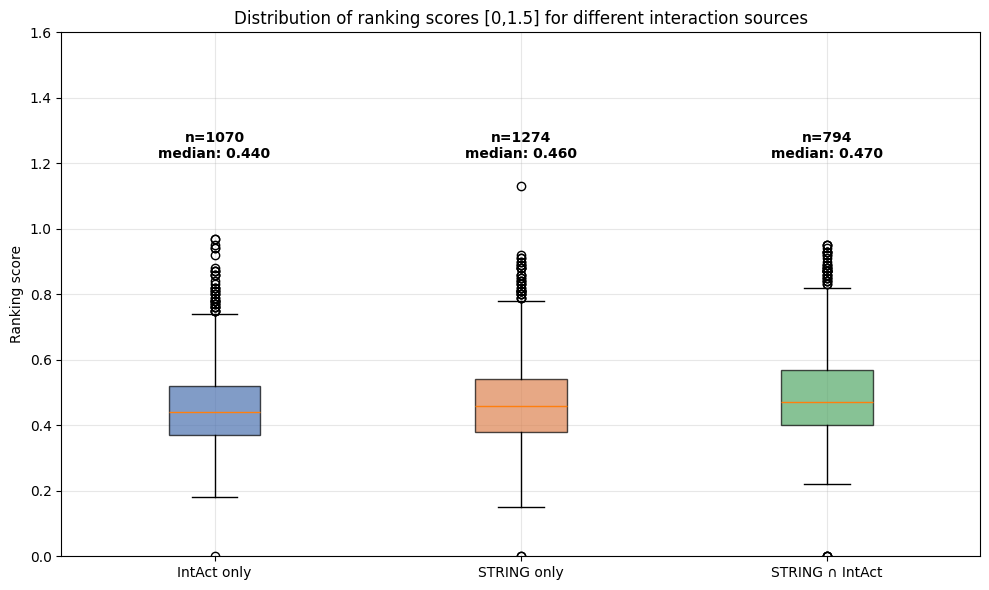

Summary statistics:
IntAct only: n=1070, median=0.440
STRING only: n=1274, median=0.460
STRING & IntAct: n=794, median=0.470


In [42]:
# Create boxplots for the three interaction datasets
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Filter out values below 0 for each dataset by setting them to 0
int_ds_results_only_IntAct_adjusted = int_ds_results_only_IntAct.copy()
int_ds_results_only_IntAct_adjusted.loc[int_ds_results_only_IntAct_adjusted['ranking_score'] < 0, 'ranking_score'] = 0

int_ds_results_only_STRING_adjusted = int_ds_results_only_STRING.copy()
int_ds_results_only_STRING_adjusted.loc[int_ds_results_only_STRING_adjusted['ranking_score'] < 0, 'ranking_score'] = 0

int_ds_results_STRING_and_INTACT_adjusted = int_ds_results_STRING_and_INTACT.copy()
int_ds_results_STRING_and_INTACT_adjusted.loc[int_ds_results_STRING_and_INTACT_adjusted['ranking_score'] < 0, 'ranking_score'] = 0

# Prepare data for boxplot
data_to_plot = [
    int_ds_results_only_IntAct_adjusted['ranking_score'],
    int_ds_results_only_STRING_adjusted['ranking_score'],
    int_ds_results_STRING_and_INTACT_adjusted['ranking_score']
]

labels = ['IntAct only', 'STRING only', 'STRING ∩ IntAct']

# Create boxplot with seaborn deep palette
colors = sns.color_palette("deep", 3)
box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)

# Apply colors
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Ranking score')
ax.set_title('Distribution of ranking scores [0,1.5] for different interaction sources')
ax.grid(True, alpha=0.3)
ax.set_ylim(0,1.6)


# Calculate medians
medians = [data.median() for data in data_to_plot]

# Add sample sizes and medians to the plot
for i, (data, median) in enumerate(zip(data_to_plot, medians)):
    ax.text(i+1, 1.3, f'n={len(data)}', 
            ha='center', va='top', fontweight='bold')
    ax.text(i+1, 1.25, f'median: {median:.3f}', 
            ha='center', va='top', fontweight='bold')

plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/interact_box1.png",dpi=300)
plt.show()

# Print summary statistics
print("Summary statistics:")
print(f"IntAct only: n={len(int_ds_results_only_IntAct_adjusted)}, median={int_ds_results_only_IntAct_adjusted['ranking_score'].median():.3f}")
print(f"STRING only: n={len(int_ds_results_only_STRING_adjusted)}, median={int_ds_results_only_STRING_adjusted['ranking_score'].median():.3f}")
print(f"STRING & IntAct: n={len(int_ds_results_STRING_and_INTACT_adjusted)}, median={int_ds_results_STRING_and_INTACT_adjusted['ranking_score'].median():.3f}")

/tmp/ipykernel_111037/741405295.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot_filtered = ax.boxplot(data_to_plot_filtered, labels=labels_filtered, patch_artist=True)


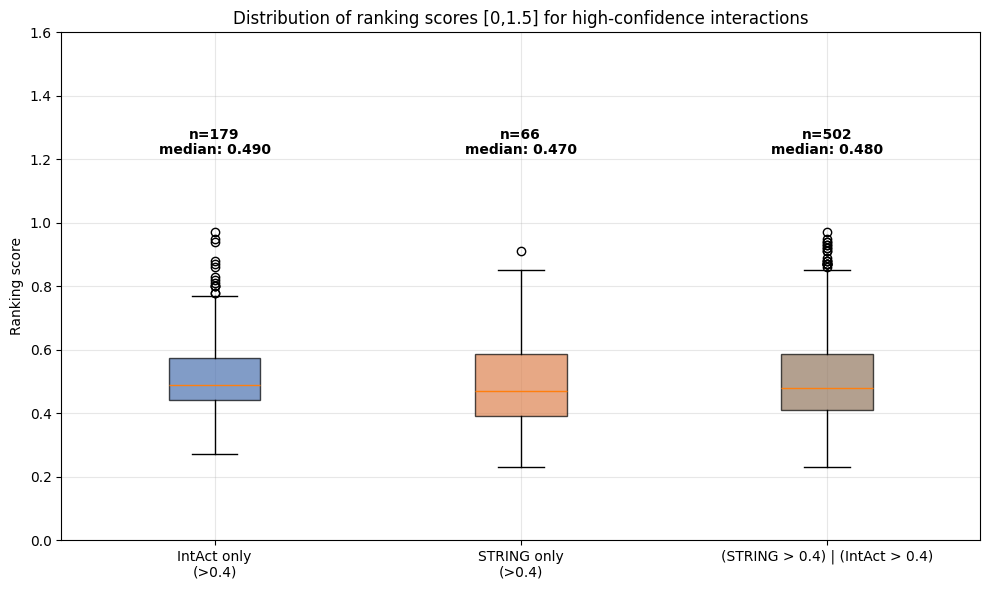

Summary statistics (filtered >0.4):
IntAct only: n=179, median=0.490
STRING only: n=66, median=0.470
Both >0.4: n=57, median=0.470
Either >0.4: n=502, median=0.480


In [43]:
# Create filtered boxplots with score thresholds
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Apply score filters
int_ds_results_only_IntAct_high = int_ds_results_only_IntAct_adjusted[
    (int_ds_results_only_IntAct[INTACT_SCORE_COLUMN] > 0.4)
]

int_ds_results_only_STRING_high = int_ds_results_only_STRING_adjusted[
    (int_ds_results_only_STRING[STRING_SCORE_COLUMN] > 0.4)
]

int_ds_results_both_high = int_ds_results_STRING_and_INTACT_adjusted[
    (int_ds_results_STRING_and_INTACT[INTACT_SCORE_COLUMN] > 0.4) & 
    (int_ds_results_STRING_and_INTACT[STRING_SCORE_COLUMN] > 0.4)
]

int_ds_results_either_high = int_ds_results[
    ((int_ds_results[INTACT_SCORE_COLUMN] > 0.4) | 
     (int_ds_results[STRING_SCORE_COLUMN] > 0.4)) &
    (int_ds_results['ranking_score'] >= 0)
]

# Prepare data for boxplot
data_to_plot_filtered = [
    int_ds_results_only_IntAct_high['ranking_score'],
    int_ds_results_only_STRING_high['ranking_score'],
    # int_ds_results_both_high['ranking_score'],
    int_ds_results_either_high['ranking_score']
]

labels_filtered = ['IntAct only\n(>0.4)', 'STRING only\n(>0.4)', '(STRING > 0.4) | (IntAct > 0.4)']

# Create boxplot with seaborn deep palette
colors_filtered = sns.color_palette("deep")
# Make the third (rightmost) color purple
colors_filtered = [colors_filtered[0], colors_filtered[1], colors_filtered[5]]  # Use index 3 for purple
box_plot_filtered = ax.boxplot(data_to_plot_filtered, labels=labels_filtered, patch_artist=True)

# Apply colors
for patch, color in zip(box_plot_filtered['boxes'], colors_filtered):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Ranking score')
ax.set_title('Distribution of ranking scores [0,1.5] for high-confidence interactions')
ax.grid(True, alpha=0.3)
ax.set_ylim(False,1.6)

# Calculate medians
medians_filtered = [data.median() for data in data_to_plot_filtered]

# Add sample sizes and medians to the plot
for i, (data, median) in enumerate(zip(data_to_plot_filtered, medians_filtered)):
    ax.text(i+1, 1.3, f'n={len(data)}', 
            ha='center', va='top', fontweight='bold')
    ax.text(i+1, 1.25, f'median: {median:.3f}', 
            ha='center', va='top', fontweight='bold')

plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/interact_box2.png",dpi=300)
plt.show()

# Print summary statistics for filtered datasets
print("Summary statistics (filtered >0.4):")
print(f"IntAct only: n={len(int_ds_results_only_IntAct_high)}, median={int_ds_results_only_IntAct_high['ranking_score'].median():.3f}")
print(f"STRING only: n={len(int_ds_results_only_STRING_high)}, median={int_ds_results_only_STRING_high['ranking_score'].median():.3f}")
print(f"Both >0.4: n={len(int_ds_results_both_high)}, median={int_ds_results_both_high['ranking_score'].median():.3f}")
print(f"Either >0.4: n={len(int_ds_results_either_high)}, median={int_ds_results_either_high['ranking_score'].median():.3f}")

In [44]:
METRIC_CUTOFF = 0.65

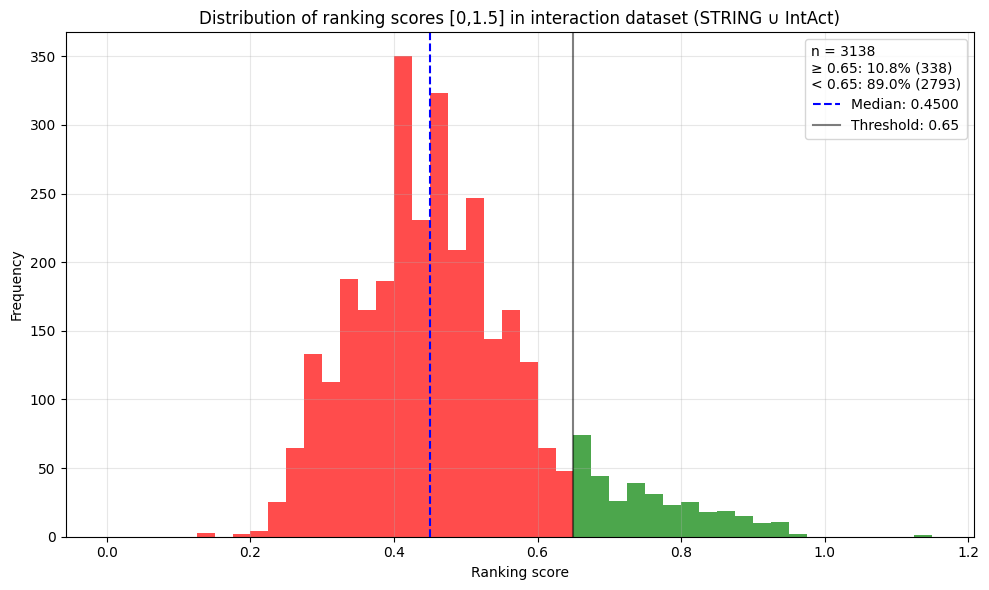

In [45]:
import seaborn as sns
import numpy as np

int_ds_results_plot = int_ds_results[int_ds_results['ranking_score'] >= 0]

plt.figure(figsize=(10, 6))

# Create a histogram with custom colors and fixed bin size of 0.1
bins = np.arange(0, max(int_ds_results_plot['ranking_score']) + 0.025, 0.025)
hist, bin_edges = np.histogram(int_ds_results_plot['ranking_score'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i in range(len(hist)):
    color = 'green' if bin_centers[i] >= METRIC_CUTOFF else 'red'
    plt.bar(bin_centers[i], hist[i], width=(bin_edges[1] - bin_edges[0]), 
            color=color, alpha=0.7, align='center')

plt.xlabel('Ranking score')
plt.ylabel('Frequency')
plt.title('Distribution of ranking scores [0,1.5] in interaction dataset (STRING ∪ IntAct)')

# Add median and sample size to legend with cutoff information
median_value = int_ds_results['ranking_score'].median()
n_samples = len(int_ds_results)
n_above_cutoff = len(int_ds_results[int_ds_results['ranking_score'] >= METRIC_CUTOFF])
n_below_cutoff = len(int_ds_results[(int_ds_results['ranking_score'] < METRIC_CUTOFF) & (int_ds_results['ranking_score'] >= 0)])

# Calculate percentages
pct_above = (n_above_cutoff / n_samples) * 100
pct_below = (n_below_cutoff / n_samples) * 100

plt.axvline(x=median_value, color='blue', linestyle='--', label=f'Median: {median_value:.4f}')
plt.axvline(x=METRIC_CUTOFF, color='black', linestyle='-', alpha=0.5, label=f'Threshold: {METRIC_CUTOFF}')
plt.legend(title=f'n = {n_samples}\n≥ {METRIC_CUTOFF}: {pct_above:.1f}% ({n_above_cutoff})\n< {METRIC_CUTOFF}: {pct_below:.1f}% ({n_below_cutoff})')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/interact_hist.png", dpi=300)
plt.show()

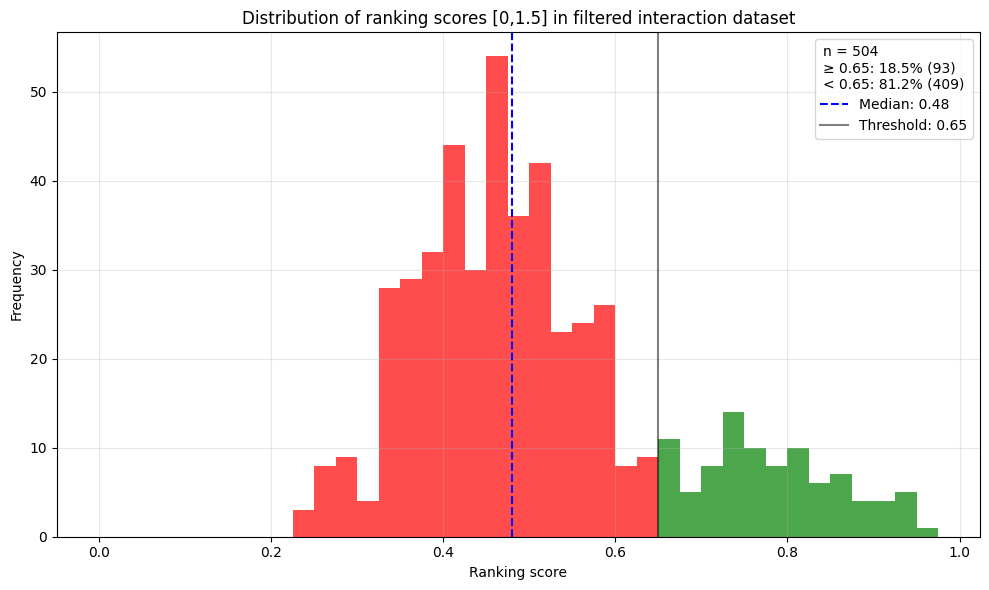

In [46]:
int_ds_results_exp_co = int_ds_results[(int_ds_results[STRING_SCORE_COLUMN] > 0.4) |  (int_ds_results[INTACT_SCORE_COLUMN] > 0.4)]

int_ds_results_exp_co_plot = int_ds_results_exp_co[int_ds_results_exp_co['ranking_score'] >= 0]

plt.figure(figsize=(10, 6))

# Create a histogram with custom colors and fixed bin size of 0.025
bins = np.arange(0, max(int_ds_results_exp_co_plot['ranking_score']) + 0.025, 0.025)
hist, bin_edges = np.histogram(int_ds_results_exp_co_plot['ranking_score'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i in range(len(hist)):
    color = 'green' if bin_centers[i] >= METRIC_CUTOFF else 'red'
    plt.bar(bin_centers[i], hist[i], width=(bin_edges[1] - bin_edges[0]), 
            color=color, alpha=0.7, align='center')

plt.xlabel('Ranking score')
plt.ylabel('Frequency')
plt.title('Distribution of ranking scores [0,1.5] in filtered interaction dataset')

# Add median and sample size to legend with cutoff information
median_value = int_ds_results_exp_co['ranking_score'].median()
n_samples = len(int_ds_results_exp_co)
n_above_cutoff = len(int_ds_results_exp_co[int_ds_results_exp_co['ranking_score'] >= METRIC_CUTOFF])
n_below_cutoff = len(int_ds_results_exp_co[(int_ds_results_exp_co['ranking_score'] < METRIC_CUTOFF) & (int_ds_results_exp_co['ranking_score'] >= 0)])

# Calculate percentages
pct_above = (n_above_cutoff / n_samples) * 100
pct_below = (n_below_cutoff / n_samples) * 100

plt.axvline(x=median_value, color='blue', linestyle='--', label=f'Median: {median_value:.2f}')
plt.axvline(x=METRIC_CUTOFF, color='black', linestyle='-', alpha=0.5, label=f'Threshold: {METRIC_CUTOFF}')
plt.legend(title=f'n = {n_samples}\n≥ {METRIC_CUTOFF}: {pct_above:.1f}% ({n_above_cutoff})\n< {METRIC_CUTOFF}: {pct_below:.1f}% ({n_below_cutoff})')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/interact_hist_exp_cutoff", dpi=300)
plt.show()

In [47]:
# create 'prediction dataset' with modeled structures
pred_ds_results = no_struct[~no_struct['combined_score'].notna()] # any one of the STRING scores is good for this filter
pred_ds_results = pred_ds_results[~pred_ds_results['intact_score'].notna()]

print(len(pred_ds))
print(len(pred_ds_results))
print(len(pred_ds_results[pred_ds_results['diso_mediating'] == True]))
pred_ds_results_diso_med = pred_ds_results[pred_ds_results['diso_mediating'] == True]
# pred_ds_results = pred_ds_results[pred_ds_results['diso_mediating'] == True]

452769
3990
1855


#### prediciton dataset plots

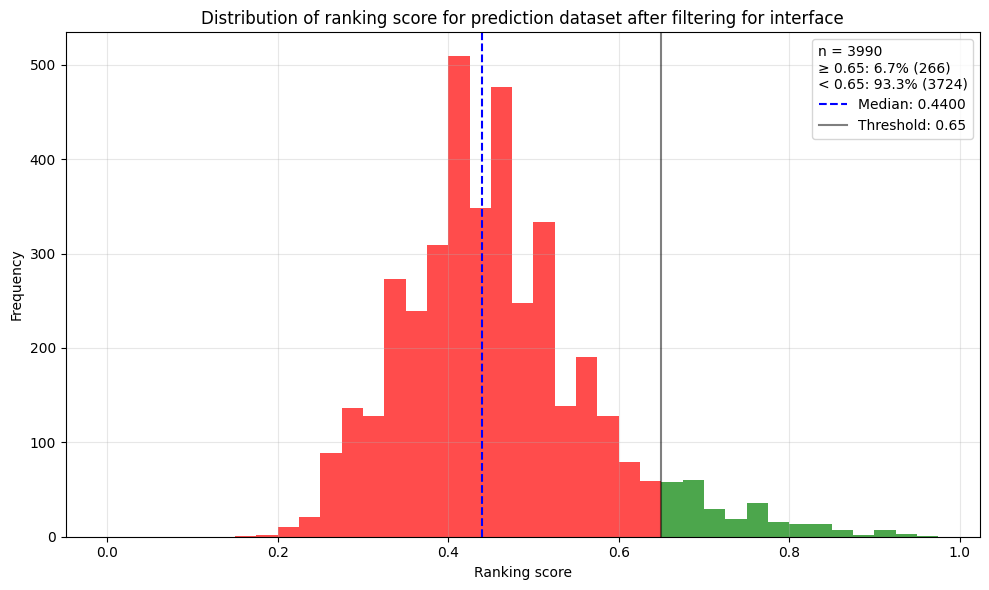

In [ ]:
plt.figure(figsize=(10, 6))

pred_ds_results_plot = pred_ds_results[(pred_ds_results['ranking_score'] >= 0)]

# Create a histogram with custom colors and fixed bin size of 0.025
bins = np.arange(0, max(pred_ds_results_plot['ranking_score']) + 0.025, 0.025)
hist, bin_edges = np.histogram(pred_ds_results_plot['ranking_score'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i in range(len(hist)):
    color = 'green' if bin_centers[i] >= METRIC_CUTOFF else 'red'
    plt.bar(bin_centers[i], hist[i], width=(bin_edges[1] - bin_edges[0]), 
            color=color, alpha=0.7, align='center')

plt.xlabel('Ranking score')
plt.ylabel('Frequency')

# Add median and sample size to legend with cutoff information
median_value = pred_ds_results['ranking_score'].median()
n_samples = len(pred_ds_results)
n_above_cutoff = len(pred_ds_results[pred_ds_results['ranking_score'] >= METRIC_CUTOFF])
n_below_cutoff = len(pred_ds_results[(pred_ds_results['ranking_score'] < METRIC_CUTOFF)])

# Calculate percentages
pct_above = (n_above_cutoff / n_samples) * 100
pct_below = (n_below_cutoff / n_samples) * 100

plt.axvline(x=median_value, color='blue', linestyle='--', label=f'Median: {median_value:.4f}')
plt.axvline(x=METRIC_CUTOFF, color='black', linestyle='-', alpha=0.5, label=f'Threshold: {METRIC_CUTOFF}')
plt.legend(title=f'n = {n_samples}\n≥ {METRIC_CUTOFF}: {pct_above:.1f}% ({n_above_cutoff})\n< {METRIC_CUTOFF}: {pct_below:.1f}% ({n_below_cutoff})')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/predict_hist.png", dpi=300)
plt.show()

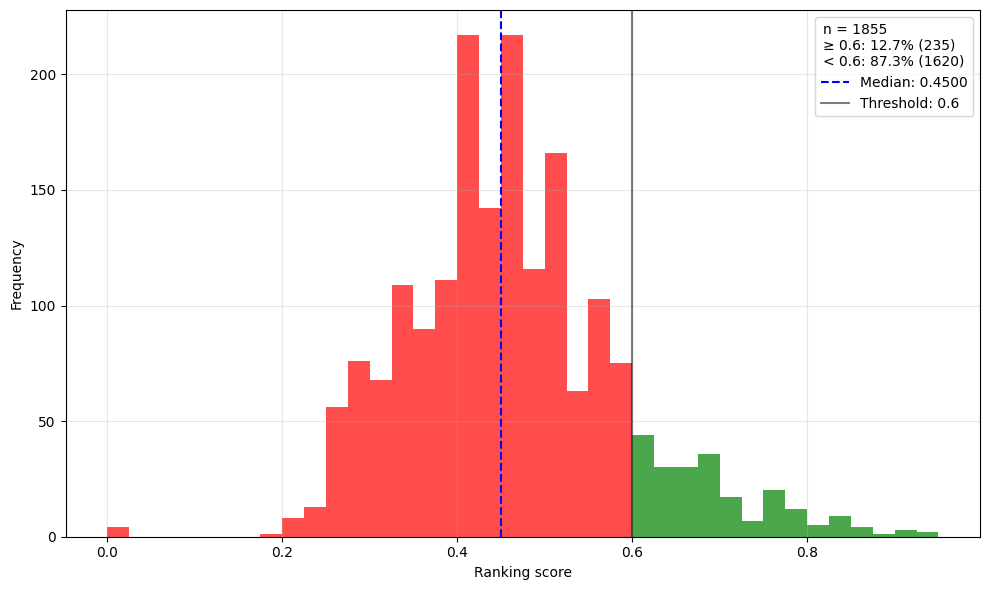

In [66]:
METRIC_CUTOFF = 0.6

plt.figure(figsize=(10, 6))

pred_ds_results_diso_med_plot = pred_ds_results_diso_med.copy()
pred_ds_results_diso_med_plot.loc[pred_ds_results_diso_med_plot['ranking_score'] < 0, 'ranking_score'] = 0

# Create a histogram with custom colors and fixed bin size of 0.025
bins = np.arange(0, max(pred_ds_results_diso_med_plot['ranking_score']) + 0.025, 0.025)
hist, bin_edges = np.histogram(pred_ds_results_diso_med_plot['ranking_score'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i in range(len(hist)):
    color = 'green' if bin_centers[i] >= METRIC_CUTOFF else 'red'
    plt.bar(bin_centers[i], hist[i], width=(bin_edges[1] - bin_edges[0]), 
            color=color, alpha=0.7, align='center')

plt.xlabel('Ranking score')
plt.ylabel('Frequency')

# Add median and sample size to legend with cutoff information
median_value = pred_ds_results_diso_med['ranking_score'].median()
n_samples = len(pred_ds_results_diso_med)
n_above_cutoff = len(pred_ds_results_diso_med[pred_ds_results_diso_med['ranking_score'] >= METRIC_CUTOFF])
n_below_cutoff = len(pred_ds_results_diso_med[(pred_ds_results_diso_med['ranking_score'] < METRIC_CUTOFF)])

# Calculate percentages
pct_above = (n_above_cutoff / n_samples) * 100
pct_below = (n_below_cutoff / n_samples) * 100

plt.axvline(x=median_value, color='blue', linestyle='--', label=f'Median: {median_value:.4f}')
plt.axvline(x=METRIC_CUTOFF, color='black', linestyle='-', alpha=0.5, label=f'Threshold: {METRIC_CUTOFF}')
plt.legend(title=f'n = {n_samples}\n≥ {METRIC_CUTOFF}: {pct_above:.1f}% ({n_above_cutoff})\n< {METRIC_CUTOFF}: {pct_below:.1f}% ({n_below_cutoff})')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/predict_hist_interface_rs.png", dpi=300)
plt.show()

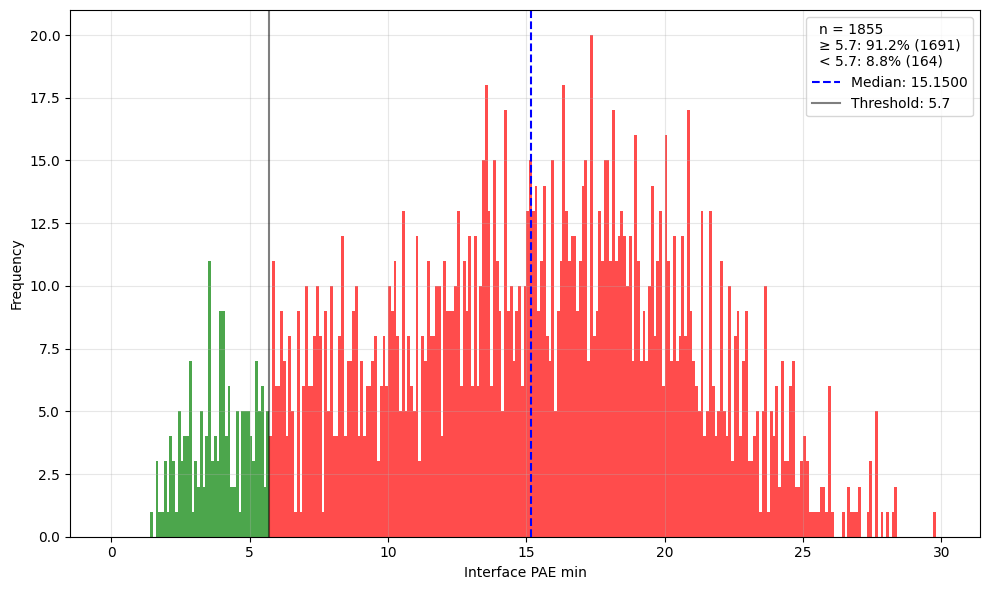

In [67]:
METRIC_CUTOFF = 5.7

plt.figure(figsize=(10, 6))

# Create a histogram with custom colors and fixed bin size of 0.025
bins = np.arange(0, 30, 0.1)
hist, bin_edges = np.histogram(pred_ds_results_diso_med_plot['interface_pae_min'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i in range(len(hist)):
    color = 'green' if bin_centers[i] <= METRIC_CUTOFF else 'red'
    plt.bar(bin_centers[i], hist[i], width=(bin_edges[1] - bin_edges[0]), 
            color=color, alpha=0.7, align='center')

plt.xlabel('Interface PAE min')
plt.ylabel('Frequency')

# Add median and sample size to legend with cutoff information
median_value = pred_ds_results_diso_med['interface_pae_min'].median()
n_samples = len(pred_ds_results_diso_med)
n_above_cutoff = len(pred_ds_results_diso_med[pred_ds_results_diso_med['interface_pae_min'] >= METRIC_CUTOFF])
n_below_cutoff = len(pred_ds_results_diso_med[(pred_ds_results_diso_med['interface_pae_min'] < METRIC_CUTOFF)])

# Calculate percentages
pct_above = (n_above_cutoff / n_samples) * 100
pct_below = (n_below_cutoff / n_samples) * 100

plt.axvline(x=median_value, color='blue', linestyle='--', label=f'Median: {median_value:.4f}')
plt.axvline(x=METRIC_CUTOFF, color='black', linestyle='-', alpha=0.5, label=f'Threshold: {METRIC_CUTOFF}')
plt.legend(title=f'n = {n_samples}\n≥ {METRIC_CUTOFF}: {pct_above:.1f}% ({n_above_cutoff})\n< {METRIC_CUTOFF}: {pct_below:.1f}% ({n_below_cutoff})')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/predict_hist_interface_ipaemin.png", dpi=300)
plt.show()

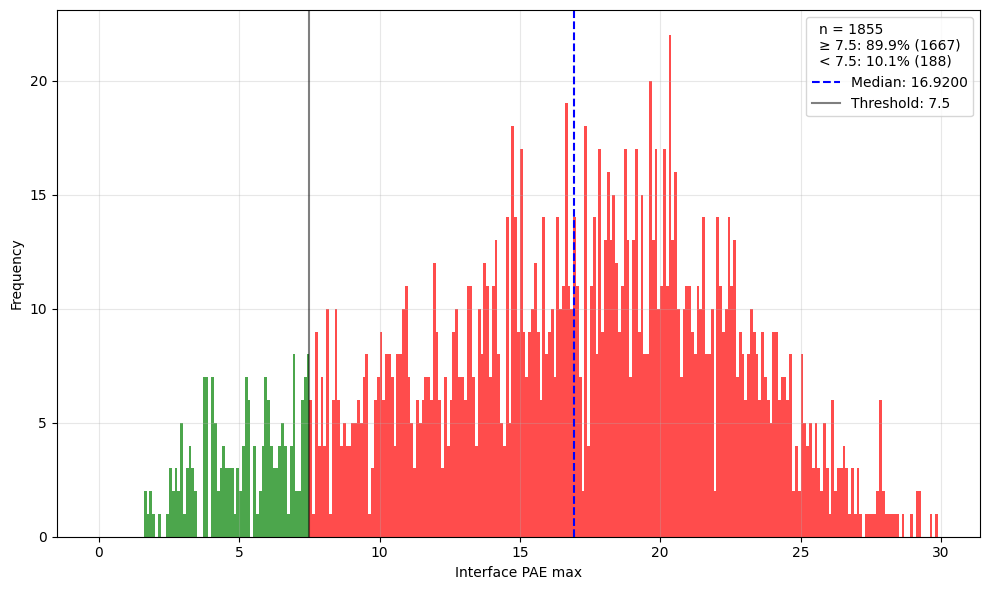

In [68]:
METRIC_CUTOFF = 7.5

plt.figure(figsize=(10, 6))

# Create a histogram with custom colors and fixed bin size of 0.025
bins = np.arange(0, 30, 0.1)
hist, bin_edges = np.histogram(pred_ds_results_diso_med_plot['interface_pae_max'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i in range(len(hist)):
    color = 'green' if bin_centers[i] <= METRIC_CUTOFF else 'red'
    plt.bar(bin_centers[i], hist[i], width=(bin_edges[1] - bin_edges[0]), 
            color=color, alpha=0.7, align='center')

plt.xlabel('Interface PAE max')
plt.ylabel('Frequency')

# Add median and sample size to legend with cutoff information
median_value = pred_ds_results_diso_med['interface_pae_max'].median()
n_samples = len(pred_ds_results_diso_med)
n_above_cutoff = len(pred_ds_results_diso_med[pred_ds_results_diso_med['interface_pae_max'] >= METRIC_CUTOFF])
n_below_cutoff = len(pred_ds_results_diso_med[(pred_ds_results_diso_med['interface_pae_max'] < METRIC_CUTOFF)])

# Calculate percentages
pct_above = (n_above_cutoff / n_samples) * 100
pct_below = (n_below_cutoff / n_samples) * 100

plt.axvline(x=median_value, color='blue', linestyle='--', label=f'Median: {median_value:.4f}')
plt.axvline(x=METRIC_CUTOFF, color='black', linestyle='-', alpha=0.5, label=f'Threshold: {METRIC_CUTOFF}')
plt.legend(title=f'n = {n_samples}\n≥ {METRIC_CUTOFF}: {pct_above:.1f}% ({n_above_cutoff})\n< {METRIC_CUTOFF}: {pct_below:.1f}% ({n_below_cutoff})')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/predict_hist_interface_ipaemax.png", dpi=300)
plt.show()

In [50]:
# Sort prediction dataset by ranking score (ascending) and print pair ID and ranking score
pred_ds_results_sorted = pred_ds_results.sort_values('ranking_score', ascending=False)

print("Pair ID\t\t\t\tRanking Score")
print("-" * 50)

for idx, row in pred_ds_results_sorted.head(10).iterrows():
    pair_id = row['job_name']
    ranking_score = row['ranking_score'] if pd.notna(row['ranking_score']) else 'N/A'
    
    print(f"{pair_id}\t\t{ranking_score}")

Pair ID				Ranking Score
--------------------------------------------------
q9h6l4_1-198_q9y4x4_1-402		0.96
o00629_1-521_q14814_1-521		0.95
p0cl84_1-134_q96km6_1-892		0.95
q9y376_1-341_p16220_1-327		0.94
a9uhw6_1-222_q9c009_1-403		0.92
q9h6l4_1-198_p43268_1-484		0.92
p52294_1-538_q9p1z0_1-1013		0.92
q8wya6_1-563_p56178_1-289		0.91
o75602_1-509_p32243_1-289		0.91
q9h6l4_1-198_q15583_1-401		0.91


/tmp/ipykernel_111037/2393044988.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)


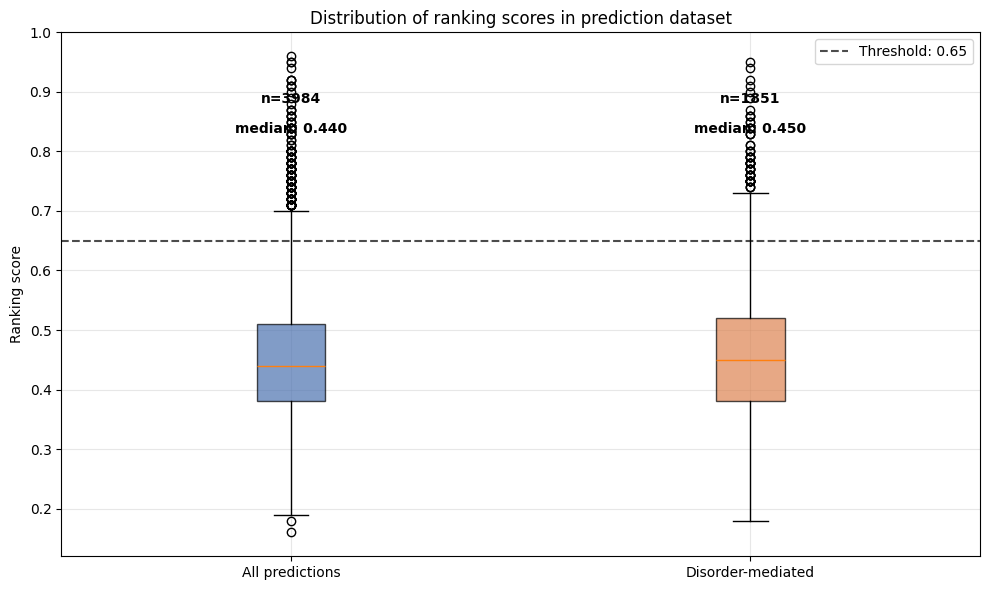

Summary statistics:
All predictions: n=3984, median=0.440
Disorder-mediated: n=1851, median=0.450
Above 0.65 threshold:
All predictions: 266 (6.7%)
Disorder-mediated: 146 (7.9%)


In [51]:
# Create boxplot comparison between pred_ds_results and pred_ds_results_diso_med
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Filter out negative ranking scores for both datasets
pred_ds_results_filtered = pred_ds_results[pred_ds_results['ranking_score'] >= 0]
pred_ds_results_diso_med_filtered = pred_ds_results_diso_med[pred_ds_results_diso_med['ranking_score'] >= 0]

# Prepare data for boxplot
data_to_plot = [
    pred_ds_results_filtered['ranking_score'],
    pred_ds_results_diso_med_filtered['ranking_score']
]

labels = ['All predictions', 'Disorder-mediated']

# Create boxplot with seaborn deep palette (blue and orange)
colors = sns.color_palette("deep", 2)  # Gets blue and orange from deep palette
box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)

# Apply colors (blue and orange)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Ranking score')
ax.set_title('Distribution of ranking scores in prediction dataset')
ax.grid(True, alpha=0.3)

# Add METRIC_CUTOFF as vertical line
ax.axhline(y=METRIC_CUTOFF, color='black', linestyle='--', alpha=0.7, label=f'Threshold: {METRIC_CUTOFF}')

# Calculate medians and sample sizes
medians = [data.median() for data in data_to_plot]
sample_sizes = [len(data) for data in data_to_plot]

# Add sample sizes and medians to the plot
for i, (data, median, n) in enumerate(zip(data_to_plot, medians, sample_sizes)):
    ax.text(i+1, ax.get_ylim()[1] * 0.9, f'n={n}', 
            ha='center', va='top', fontweight='bold')
    ax.text(i+1, ax.get_ylim()[1] * 0.85, f'median: {median:.3f}', 
            ha='center', va='top', fontweight='bold')

ax.legend()
plt.tight_layout()
plt.savefig("/home/markus/Desktop/Thesis/pred_comparison_boxplot.png", dpi=300)
plt.show()

# Print summary statistics
print("Summary statistics:")
print(f"All predictions: n={len(pred_ds_results_filtered)}, median={pred_ds_results_filtered['ranking_score'].median():.3f}")
print(f"Disorder-mediated: n={len(pred_ds_results_diso_med_filtered)}, median={pred_ds_results_diso_med_filtered['ranking_score'].median():.3f}")

# Print counts above/below cutoff
n_above_all = len(pred_ds_results_filtered[pred_ds_results_filtered['ranking_score'] >= METRIC_CUTOFF])
n_above_diso = len(pred_ds_results_diso_med_filtered[pred_ds_results_diso_med_filtered['ranking_score'] >= METRIC_CUTOFF])
pct_above_all = (n_above_all / len(pred_ds_results_filtered)) * 100
pct_above_diso = (n_above_diso / len(pred_ds_results_diso_med_filtered)) * 100

print(f"Above {METRIC_CUTOFF} threshold:")
print(f"All predictions: {n_above_all} ({pct_above_all:.1f}%)")
print(f"Disorder-mediated: {n_above_diso} ({pct_above_diso:.1f}%)")

### Comparing AlphaFold ranking scores with STRING combined scores

In [52]:
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# STRING_SCORE_COLUMN = 'experimental'
# INTACT_SCORE_COLUMN = 'intact_score'

# create_heatmap(results_df_annotated.dropna(subset=[STRING_SCORE_COLUMN]), 'iptm', STRING_SCORE_COLUMN, ax=axes[0], scatter_threshold=2)
# create_heatmap(results_df_annotated.dropna(subset=[STRING_SCORE_COLUMN]), 'ptm', STRING_SCORE_COLUMN, ax=axes[1], scatter_threshold=2)
# create_heatmap(results_df_annotated.dropna(subset=[STRING_SCORE_COLUMN]), 'ranking_score', STRING_SCORE_COLUMN, ax=axes[2], scatter_threshold=2)

# fig.suptitle('AlphaFold Metrics vs STRING score, NAs dropped', fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for subtitle
# plt.show()


# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# create_heatmap(results_df_annotated.dropna(subset=[INTACT_SCORE_COLUMN]), 'iptm', INTACT_SCORE_COLUMN, ax=axes[0])
# create_heatmap(results_df_annotated.dropna(subset=[INTACT_SCORE_COLUMN]), 'ptm', INTACT_SCORE_COLUMN, ax=axes[1])
# create_heatmap(results_df_annotated.dropna(subset=[INTACT_SCORE_COLUMN]), 'ranking_score', INTACT_SCORE_COLUMN, ax=axes[2])

# fig.suptitle('AlphaFold Metrics vs IntAct score, NAs dropped', fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for subtitle
# plt.show()

In [53]:
# fig, ax = create_overlaid_AF_violin_plot(
#     dataset1=results_df_annotated,
#     dataset1_name='all pairs', 
#     dataset2=report_2_pairs,
#     dataset2_name='report 2',
#     figsize=(12, 6)
# )
# plt.show()

# co = 0.9
# string_high_scoring = results_df_annotated.dropna(subset=[STRING_SCORE_COLUMN])
# string_high_scoring = string_high_scoring[string_high_scoring[STRING_SCORE_COLUMN] > co]

# fig, ax = create_overlaid_AF_violin_plot(
#     dataset1=string_high_scoring,
#     dataset1_name=f"STRING high scoring {co}", 
#     dataset2=results_df_annotated,
#     dataset2_name='all pairs',
#     figsize=(12, 6)
# )
# plt.show()


# fig, ax = create_overlaid_AF_violin_plot(
#     dataset1=results_df_annotated.dropna(subset=[STRING_SCORE_COLUMN]),
#     dataset1_name='STRING', 
#     dataset2=results_df_annotated.dropna(subset=[INTACT_SCORE_COLUMN]),
#     dataset2_name='IntAct',
#     figsize=(12, 6)
# )
# plt.show()


# fig, ax = create_overlaid_AF_violin_plot(
#     dataset1=results_df_annotated.dropna(subset=[STRING_SCORE_COLUMN]),
#     dataset1_name='STRING', 
#     dataset2=results_df_annotated,
#     dataset2_name='all pairs',
#     figsize=(12, 6)
# )
# plt.show()

# fig, ax = create_overlaid_AF_violin_plot(
#     dataset1=results_df_annotated.dropna(subset=[INTACT_SCORE_COLUMN]),
#     dataset1_name='IntAct', 
#     dataset2=results_df_annotated,
#     dataset2_name='all pairs',
#     figsize=(12, 6)
# )
# plt.show()

In [54]:
# # FIXME: should I include duplicate values?
# prediction_IntAct = results_df_annotated[results_df_annotated[INTACT_SCORE_COLUMN].notna()]
# prediction_IntAct_plot = prediction_IntAct[prediction_IntAct['ranking_score'] >= 0]

# prediction_STRING = results_df_annotated[results_df_annotated[STRING_SCORE_COLUMN].notna()]
# prediction_STRING_plot = prediction_STRING[prediction_STRING['ranking_score'] >= 0]

# print(len(prediction_IntAct[prediction_IntAct['ranking_score']>=0.65]))
# print(len(prediction_IntAct[prediction_IntAct['ranking_score']<0.65]))
# print(len(prediction_STRING[prediction_STRING['ranking_score']>=0.65]))
# print(len(prediction_STRING[prediction_STRING['ranking_score']<0.65]))


# fig, ax = create_double_violin_plot(prediction_IntAct_plot, 'IntAct', prediction_STRING_plot, 'STRING (experimental)', 'ranking_score', 'ranking_score', (8,8))
# plt.axhline(y=0.65, color='red', linestyle='--', alpha=0.7, label='y=0.65')
# plt.legend()

In [55]:
# prediction_IntAct_cutoff = prediction_IntAct[prediction_IntAct[INTACT_SCORE_COLUMN] > 0.4]
# prediction_IntAct_cutoff_plot = prediction_IntAct_cutoff[prediction_IntAct_cutoff['ranking_score'] >= 0]

# prediction_STRING_cutoff = prediction_STRING[prediction_STRING[STRING_SCORE_COLUMN] > 0.4]
# prediction_STRING_cutoff_plot = prediction_STRING_cutoff[prediction_STRING_cutoff['ranking_score'] >= 0]

In [56]:
# print(len(prediction_IntAct_cutoff[prediction_IntAct_cutoff['ranking_score']>=0.65]))
# print(len(prediction_IntAct_cutoff[prediction_IntAct_cutoff['ranking_score']<0.65]))
# print(len(prediction_STRING_cutoff[prediction_STRING_cutoff['ranking_score']>=0.65]))
# print(len(prediction_STRING_cutoff[prediction_STRING_cutoff['ranking_score']<0.65]))

In [57]:
# fig, ax = create_double_violin_plot(prediction_IntAct_cutoff_plot, 'IntAct', prediction_STRING_cutoff_plot, 'STRING (experimental)', 'ranking_score', 'ranking_score', (8,8))
# plt.axhline(y=0.65, color='red', linestyle='--', alpha=0.7, label='y=0.65')
# plt.legend()

In [58]:
# prediction_set = results_df_annotated[(~results_df_annotated[STRING_SCORE_COLUMN].notna()) & (~results_df_annotated[INTACT_SCORE_COLUMN].notna())]

# plt.figure(figsize=(10, 6))
# below_cutoff = prediction_set[(prediction_set['ranking_score'] < 0.65) & (prediction_set['ranking_score'] > 0)]['ranking_score']
# above_cutoff = prediction_set[prediction_set['ranking_score'] >= 0.65]['ranking_score']

# plt.hist(below_cutoff, bins=18, alpha=0.7, color='red', label=f'Below 0.65 (n={len(below_cutoff)})')
# plt.hist(above_cutoff, bins=17, alpha=0.7, color='green', label=f'Above/Equal 0.65 (n={len(above_cutoff)})')

# plt.axvline(x=0.65, color='black', linestyle='--', linewidth=2, label='Cutoff = 0.65')
# plt.xlabel('Ranking Score')
# plt.ylabel('Frequency')
# plt.title('Distribution of Ranking Scores in Prediction Set')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

### ROC curves

creating AUC curves with STRING / IntAct alone does not really make sense. My understanding is that both include only **positive** interaction candidates and assign scores to the certainty. So even a low score means a relatively high probability of interaction because the candidate is in the DB.